In [1]:
# import all required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape,Conv2D,Conv2DTranspose,LeakyReLU,BatchNormalization,Dropout,Flatten

import time
from google.colab import files
import cv2

from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and Prepare the dataset

In [3]:
X_data = []
Y_data = []

path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Class "
for i in range(5):
  files = glob.glob(path + str(i+1) + "/*.png")
  for myFile in files:
    image = cv2.imread(myFile,0)
    reshapeimg = cv2.resize(image, dsize=(64, 64)).astype('float32')
    X_data.append (reshapeimg)
    Y_data.append (i+1)

X_data = np.array(X_data)
Y_data = np.array(Y_data)
X = X_data.astype('float32')
# scale from [0,255] to [0,1]
X = X / 255

BUFFER_SIZE = 6000
BATCH_SIZE = 128

In [4]:
# Batch and Shuffle the data

train_set = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Define the architectures for generator and discriminator

In [ ]:
# Architecture for Generator

def generator_model(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 1024 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(Reshape((4, 4, 1024)))
  # upsample to 8x8
  model.add(Conv2DTranspose(512, (5,5), strides=(2,2), activation='relu', padding='same'))
  model.add(BatchNormalization())
  # upsample to 16x16
  model.add(Conv2DTranspose(256, (5,5), strides=(2,2), activation='relu', padding='same'))
  model.add(BatchNormalization())
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (5,5), strides=(2,2), activation='relu', padding='same'))
  model.add(BatchNormalization())
  # upsample to 64x64
  model.add(Conv2DTranspose(3, (5,5), strides=(2,2), activation='relu', padding='same'))
  model.add(BatchNormalization())
  # output layer
  model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
  model.add(BatchNormalization())
  return model

generator = generator_model()

noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0,:,:,0], cmap='gray')


In [6]:
# Architecture for Discriminator Model

def discriminator_model(in_shape=(64,64,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(3, (5,5), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
	# downsample
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # downsample
  model.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # downsample
  model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # downsample
  model.add(Conv2D(1024, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
discriminator = discriminator_model()
decision_output = discriminator(generated_img)

### Define loss and optimizers for our model

In [8]:
s_true_loss = []
s_fake_loss = []
s_total_loss = []
s_gen_loss = []
s_disc_loss = []
s_true_accu = []
s_fake_accu = []

In [9]:
# compute CrossEntropyLoss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [10]:
# Define discriminator loss

def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output)  * 0.9, true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    s_true_loss.append(true_loss)
    s_fake_loss.append(fake_loss)
    s_total_loss.append(tot_loss)
    return tot_loss


In [11]:
# Define Generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# Defining separate optimizers for generator and discriminator
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

### Saving Checkpoints

In [13]:
checkpoints_dir = './training_chpk'
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer, dis_optimizer=dis_optimizer, generator=generator, discriminator=discriminator)


### Define number of epochs and examples to generate

In [14]:
EPOCHS = 2000

noise_dim = 100
num_ex_to_gen = 100

seed = tf.random.normal([num_ex_to_gen,noise_dim])

In [15]:

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)
        true_accu = np.mean(np.array(true_output>0.5)*1)
        fake_accu = np.mean(np.array(fake_output<0.5)*1)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)
        s_gen_loss.append(gen_loss)
        s_disc_loss.append(disc_loss)
        s_true_accu.append(true_accu)
        s_fake_accu.append(fake_accu)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))


In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 12 EPOCHS
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            generate_and_save_images(generator, epochs, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generator after final epoch
        # display.clear_output(wait=True)
        # generate_and_save_images(generator, epochs, seed)


### Generate and save images

In [17]:
def generate_and_save_images(model, epoch, test_input):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    plt.figure(figsize=(10,6))
    plt.plot(s_true_loss,label='True')
    plt.plot(s_fake_loss,label='Fake')
    plt.plot(s_total_loss,label='Total')
    plt.xlabel('batch')
    plt.ylabel('Loss')
    plt.title('Loss Discriminator')
    plt.legend()
    plt.savefig('LossD_at_epoch_{:04d}.png'.format(epoch))
    plt.grid()
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(s_gen_loss,label='Geneator Loss')
    plt.xlabel('batch')
    plt.ylabel('Loss')
    plt.title('Loss Generator')
    plt.legend()
    plt.savefig('LossG_at_epoch_{:04d}.png'.format(epoch))
    plt.grid()
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(s_true_accu,label='True')
    plt.plot(s_fake_accu,label='Fake')
    plt.xlabel('batch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Discriminator')
    plt.legend()
    plt.savefig('Accuracy_at_epoch_{:04d}.png'.format(epoch))
    plt.grid()
    plt.show()
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    # files.download('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


### Train model

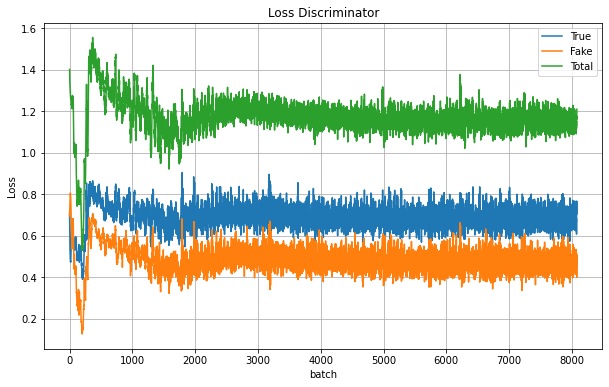

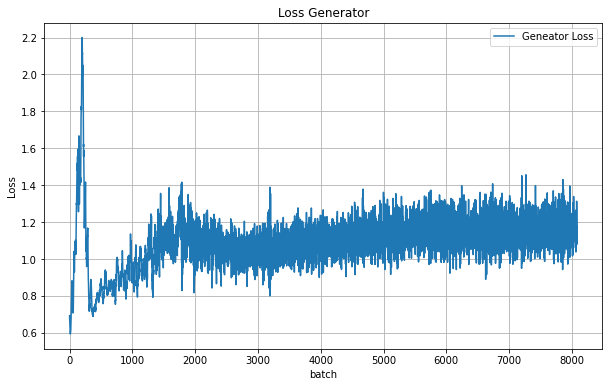

KeyboardInterrupt: ignored

In [18]:
# %%time
train(train_set, EPOCHS)

### Restore the latest checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))
